In [1]:
import pandas as pd
import numpy as np
import joblib
from lightgbm import LGBMClassifier
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

C:\Users\stefa\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
final_lgbm = joblib.load('../backend/models/lgbm/model.pkl')
final_lgbm

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.2, max_depth=10,
               n_estimators=200, n_jobs=-1, random_state=10, subsample=0.6,
               verbose=-1)

In [18]:
df = pd.read_csv('../kaggle_dataset/news_tfidf_text.csv')
df.head()

,accord,add,allow,already,also,america,american,among,another,appear,...,win,without,woman,work,world,would,write,year,yet,lbl
0,0.000000,0.0,0.037253,0.072356,0.045443,0.000000,0.026805,0.000000,0.0,0.036397,...,0.000000,0.07152,0.036966,0.000000,0.000000,0.022013,0.000000,0.046083,0.000000,1
1,0.000000,0.0,0.000000,0.089630,0.000000,0.000000,0.000000,0.000000,0.0,0.090173,...,0.000000,0.00000,0.091581,0.000000,0.077949,0.054537,0.000000,0.000000,0.000000,1
2,0.000000,0.0,0.000000,0.000000,0.000000,0.096716,0.231899,0.103827,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066448,0.000000,0
3,0.066107,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.074316,0.0,0.000000,...,0.000000,0.00000,0.000000,0.112672,0.000000,0.000000,0.070498,0.000000,0.000000,1
4,0.000000,0.0,0.000000,0.000000,0.050593,0.000000,0.000000,0.000000,0.0,0.000000,...,0.547702,0.00000,0.000000,0.000000,0.000000,0.049015,0.000000,0.051305,0.081349,0


In [19]:
Y = df['lbl']
x = df.drop(columns= 'lbl')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5068, 184), (1267, 184), (5068,), (1267,))

In [7]:
#global shap
explainer = shap.TreeExplainer(final_lgbm)
shap_values = explainer.shap_values(X_test)

C:\Users\stefa\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


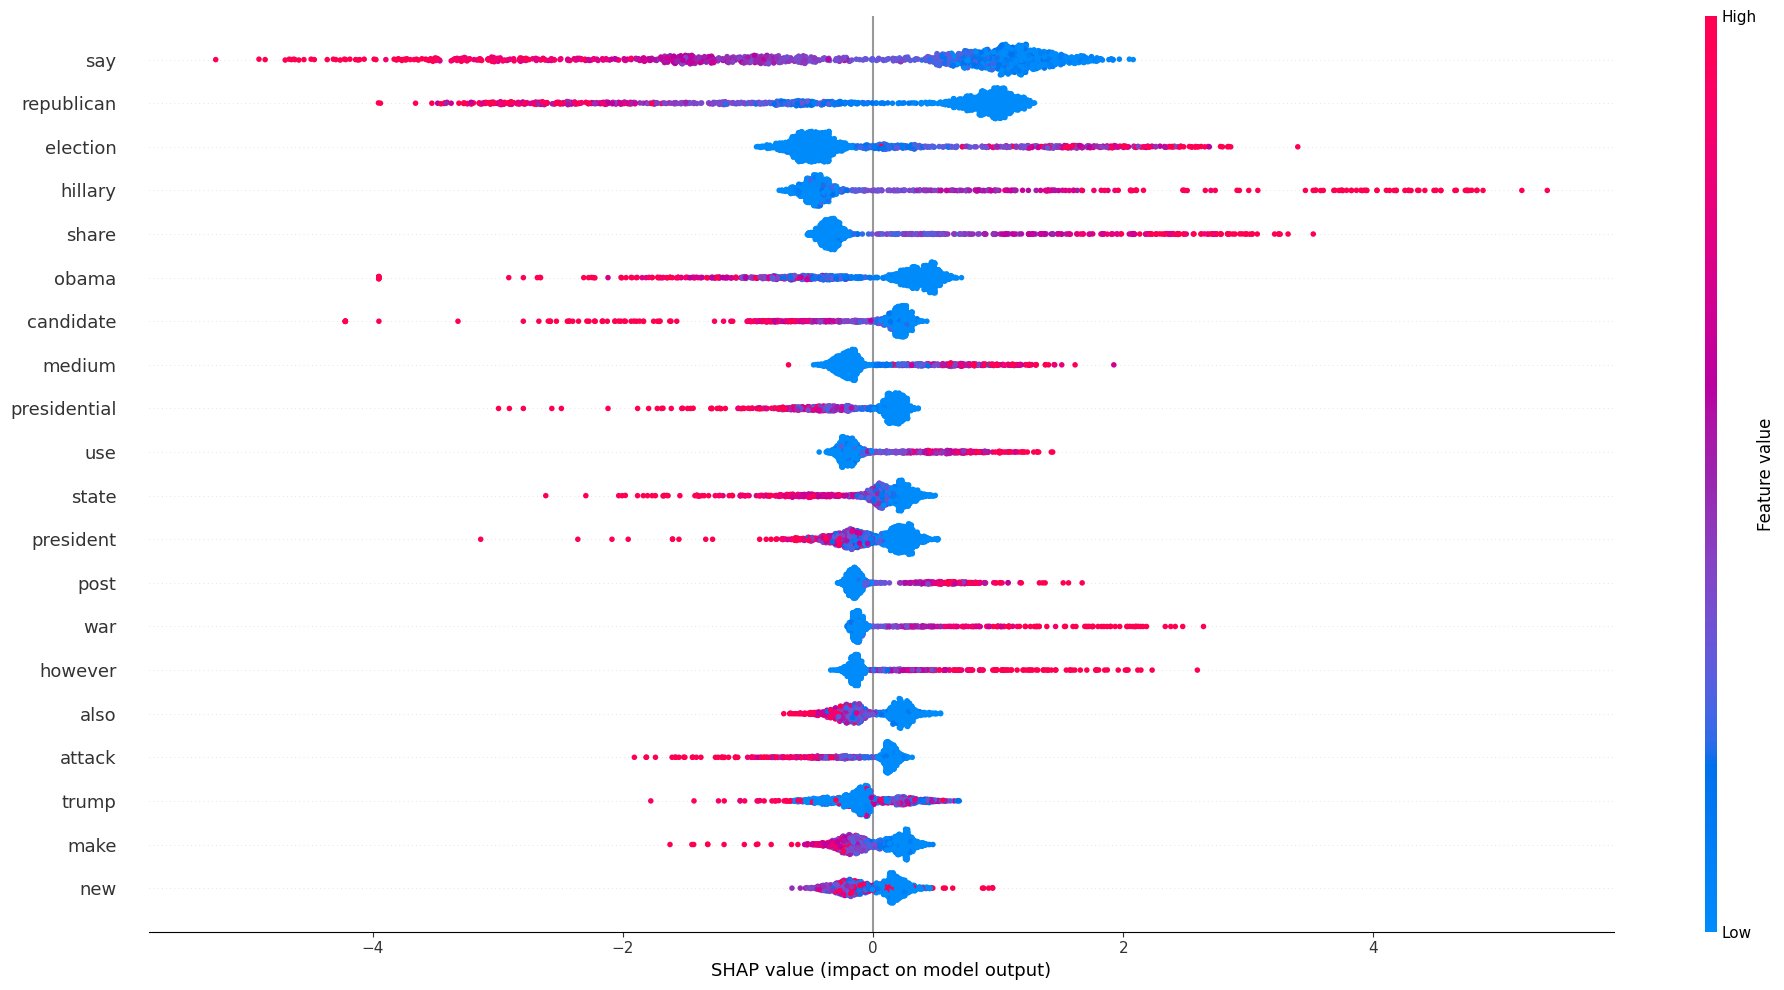

In [8]:
shap.summary_plot(shap_values, X_test, plot_size = (20, 10))

In [9]:
def computeMetrics(y_test, Y_predict_test):
    accuracy_lgbm = accuracy_score(y_test, Y_predict_test)
    print('Accuracy is: ', accuracy_lgbm)
    precision_lgbm = precision_score(y_test, Y_predict_test)
    recall_lgbm = recall_score(y_test, Y_predict_test)
    print('Precision is: ', precision_lgbm)
    print('Recall is: ', recall_lgbm)
    roc_auc_test = roc_auc_score(y_test, Y_predict_test)
    print('AUC is: ', roc_auc_test)

def confusionMatrix(y_test, Y_predict_test):
    cm_lgbm = confusion_matrix(y_test, Y_predict_test)
    #visualise confusion matrix
    fig, ax = plt.subplots(figsize = (8, 6))
    sns.heatmap(cm_lgbm, annot = True, fmt = 'd') #with annotations formatted as decimal
    plt.show()

Testing other algorithms...

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
models = {'random forest':RandomForestClassifier(n_estimators=100, random_state=42),
         'naive bayes':GaussianNB(),
         'logistic regression':LogisticRegression(max_iter=200),
         'svm':SVC(kernel='linear')}

In [14]:
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_predict_test = model.predict(X_test)
    results.append({
        'name':model_name,
        'accuracy':accuracy_score(y_test, y_predict_test),
        'precision':precision_score(y_test, y_predict_test),
        'recall':recall_score(y_test, y_predict_test),
        'ROC_AUC':roc_auc_score(y_test, y_predict_test)
    })

y_predict_test = final_lgbm.predict(X_test)
results.append({
    'name':'tuned lgbm',
    'accuracy':accuracy_score(y_test, y_predict_test),
    'precision':precision_score(y_test, y_predict_test),
    'recall':recall_score(y_test, y_predict_test),
    'ROC_AUC':roc_auc_score(y_test, y_predict_test)
})
    

    
df = pd.DataFrame(results)
df

,name,accuracy,precision,recall,ROC_AUC
0,random forest,0.854775,0.849750,0.844113,0.854285
1,naive bayes,0.758485,0.764706,0.711443,0.756324
2,logistic regression,0.820047,0.801932,0.825871,0.820315
3,svm,0.827151,0.810680,0.830846,0.827320
4,tuned lgbm,0.876875,0.862237,0.882255,0.877122


In [20]:
#tuning random forest
param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [4, 5, 8, 10, 15],
    'min_samples_split': [2, 5, 10]
}
#trying all combinations here and saving them in a dataframe called results
results = []
for estimator in param_grid['n_estimators']:
  for depth in param_grid['max_depth']:
    for min_sample_split in param_grid['min_samples_split']:
      model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, min_samples_split=min_sample_split,
                                    n_jobs=-1, random_state=42)
      #fitting each model
      model.fit(X_train, y_train)
      #running propensity models
      y_predict_test = model.predict_proba(X_test)[:, 1]
      y_predict_train = model.predict_proba(X_train)[:, 1]
      #computing auc scores for each
      auc_score_train = roc_auc_score(y_train, y_predict_train)
      auc_score_test = roc_auc_score(y_test, y_predict_test)
      #adding to results
      results.append({
          'n_estimators' : estimator,
          'max_depth' : depth,
          'min_sample_split' : min_sample_split,
          'auc_train' : auc_score_train,
          'auc_test' : auc_score_test,
          'auc_diff' : auc_score_train-auc_score_test
      })
results_df = pd.DataFrame(results)

In [24]:
from sklearn.naive_bayes import MultinomialNB
#tuning naive bayes
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0],
    'fit_prior': [True, False]
}

results = []

for alpha in param_grid['alpha']:
    for fit_prior in param_grid['fit_prior']:
        model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
        #fitting each model
        model.fit(X_train, y_train)
        #running propensity models
        y_predict_test = model.predict_proba(X_test)[:, 1]
        y_predict_train = model.predict_proba(X_train)[:, 1]
          #computing auc scores for each
        auc_score_train = roc_auc_score(y_train, y_predict_train)
        auc_score_test = roc_auc_score(y_test, y_predict_test)
          #adding to results
        results.append({
            'alpha' : alpha,
            'fit_prior' : fit_prior,
            'auc_train' : auc_score_train,
            'auc_test' : auc_score_test,
            'auc_diff' : auc_score_train-auc_score_test
        })

results_df = pd.DataFrame(results)

In [28]:
#tuning SVM
C = [0.01, 0.1, 1, 10, 100]
results = []
for c in C:
    model = SVC(C=c, probability=True, kernel='linear')
    #fitting each model
    model.fit(X_train, y_train)
    #running propensity models
    y_predict_test = model.predict_proba(X_test)[:, 1]
    y_predict_train = model.predict_proba(X_train)[:, 1]
    #computing auc scores for each
    auc_score_train = roc_auc_score(y_train, y_predict_train)
    auc_score_test = roc_auc_score(y_test, y_predict_test)
      #adding to results
    results.append({
        'C' : c,
        'auc_train' : auc_score_train,
        'auc_test' : auc_score_test,
        'auc_diff' : auc_score_train-auc_score_test
    })
results_df = pd.DataFrame(results)

In [30]:
#tuning logistic regression
C = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2']
solvers = ['liblinear', 'saga']
max_iters = [100, 200, 300, 500]
results = []
for c in C:
    for solver in solvers:
        for penalty in penalties:
            for max_iter in max_iters:
                model = LogisticRegression(C=c, penalty=penalty, solver=solver, max_iter=max_iter)
                model.fit(X_train, y_train)
                #running propensity models
                y_predict_test = model.predict_proba(X_test)[:, 1]
                y_predict_train = model.predict_proba(X_train)[:, 1]
                #computing auc scores for each
                auc_score_train = roc_auc_score(y_train, y_predict_train)
                auc_score_test = roc_auc_score(y_test, y_predict_test)
                  #adding to results
                results.append({
                    'C' : c,
                    'solver':solver,
                    'penalty':penalty,
                    'max_iter':max_iter,
                    'auc_train' : auc_score_train,
                    'auc_test' : auc_score_test,
                    'auc_diff' : auc_score_train-auc_score_test
                })
results_df = pd.DataFrame(results)

In [ ]:
results_df.sort_values(by = 'auc_test', ascending = False).head(20)

In [33]:
final_models = {
    'lgbm' : final_lgbm,
    'random forest' : RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=2, random_state=42, n_jobs=-1),
    'multinomial naive bayes' : MultinomialNB(alpha=1, fit_prior=True),
    'linear SVM' : SVC(C=1, probability=True, kernel='linear'),
    'logistic regression' : LogisticRegression(C=10, solver='liblinear', penalty='l1', max_iter=100)
}
final_results = []
for model_name, model in final_models.items():
    model.fit(X_train, y_train)
    #running propensity models
    y_predict_test = model.predict_proba(X_test)[:, 1]
    y_predict_train = model.predict_proba(X_train)[:, 1]
    #computing auc scores for each
    auc_score_train = roc_auc_score(y_train, y_predict_train)
    auc_score_test = roc_auc_score(y_test, y_predict_test)

    final_results.append({
        'model name':model_name,
        'auc_train' : auc_score_train,
        'auc_test' : auc_score_test,
        'auc_diff' : auc_score_train-auc_score_test
    })
final_results_df = pd.DataFrame(final_results)
final_results_df.sort_values(by = 'auc_test', ascending = False)

,model name,auc_train,auc_test,auc_diff
0,lgbm,1.000000,0.942167,0.057833
1,random forest,0.999576,0.923153,0.076424
4,logistic regression,0.925589,0.907024,0.018565
3,linear SVM,0.921878,0.903864,0.018014
2,multinomial naive bayes,0.874585,0.859688,0.014897


Best model is LGBM

In [14]:
split_importances = final_lgbm.feature_importances_
gain_importances = final_lgbm.booster_.feature_importance(importance_type='gain')
feature_names = final_lgbm.feature_name_

importance_df = pd.DataFrame({
    'feature':feature_names,
    'gain':gain_importances,
    'split':split_importances
})

importance_df['gain'] = 100 * importance_df['gain']/importance_df['gain'].sum()

importance_df


,feature,gain,split
0,accord,0.422096,42
1,add,0.144283,18
2,allow,0.186465,24
3,already,0.048109,14
4,also,0.547220,51
...,...,...,...
179,world,1.131968,43
180,would,0.538931,55
181,write,0.242539,24
182,year,0.224545,50


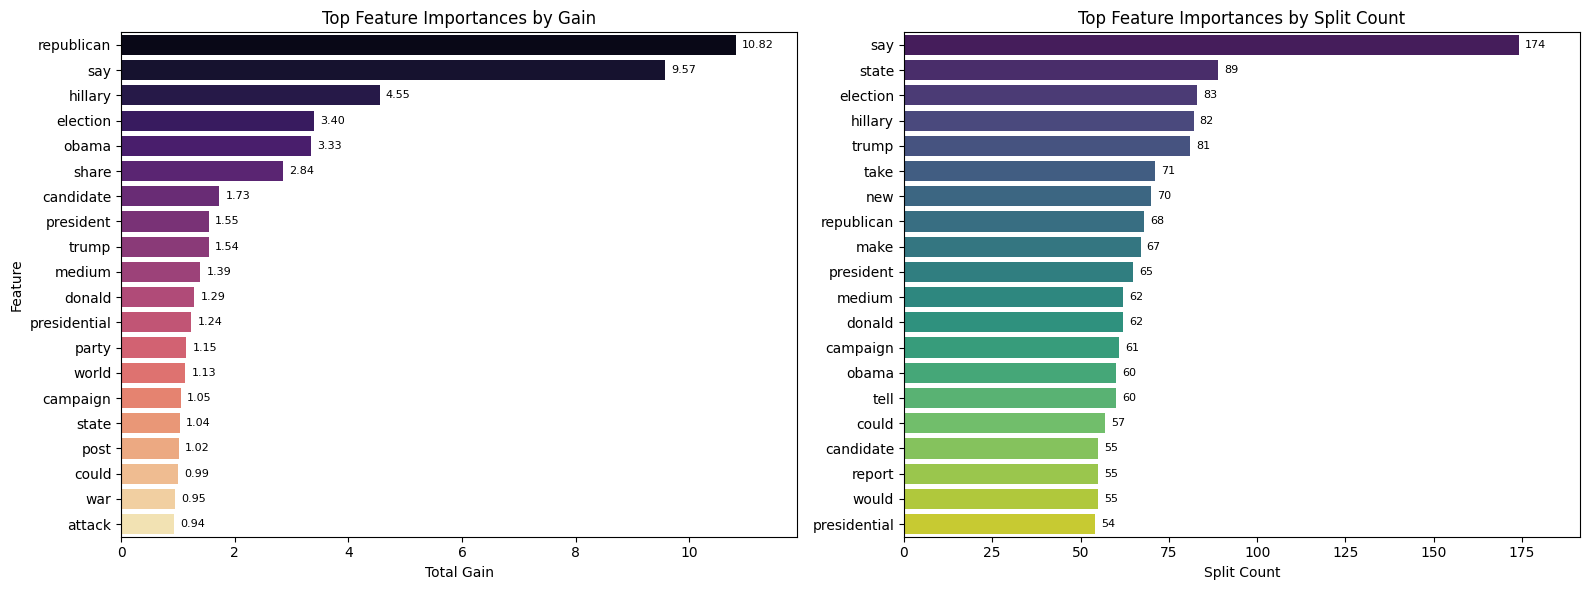

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 20
top_n = 20
plt.figure(figsize=(16, 6))  # Slightly wider

# Plot Gain
ax1 = plt.subplot(1, 2, 1)
gain_data = importance_df[['feature', 'gain']].sort_values(by='gain', ascending=False).head(top_n)
sns.barplot(
    data=gain_data,
    x='gain',
    y='feature',
    hue='feature',
    legend=False,
    palette='magma',
    ax=ax1
)
plt.title('Top Feature Importances by Gain')
plt.xlabel('Total Gain')
plt.ylabel('Feature')

# Add value labels with offset
gain_max = gain_data['gain'].max()
for i, (value, feature) in enumerate(zip(gain_data['gain'], gain_data['feature'])):
    ax1.text(value + 0.01 * gain_max, i, f'{value:.2f}', va='center', ha='left', fontsize=8)

# Extend x-axis
ax1.set_xlim(0, gain_max * 1.1)

# Plot Split
ax2 = plt.subplot(1, 2, 2)
split_data = importance_df[['feature', 'split']].sort_values(by='split', ascending=False).head(top_n)
sns.barplot(
    data=split_data,
    x='split',
    y='feature',
    hue='feature',
    legend=False,
    palette='viridis',
    ax=ax2
)
plt.title('Top Feature Importances by Split Count')
plt.xlabel('Split Count')
plt.ylabel('')

# Add value labels with offset
split_max = split_data['split'].max()
for i, (value, feature) in enumerate(zip(split_data['split'], split_data['feature'])):
    ax2.text(value + 0.01 * split_max, i, f'{value:.0f}', va='center', ha='left', fontsize=8)

# Extend x-axis
ax2.set_xlim(0, split_max * 1.1)

plt.tight_layout()
plt.show()


C:\Users\stefa\AppData\Local\Temp\ipykernel_2844\1425156707.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


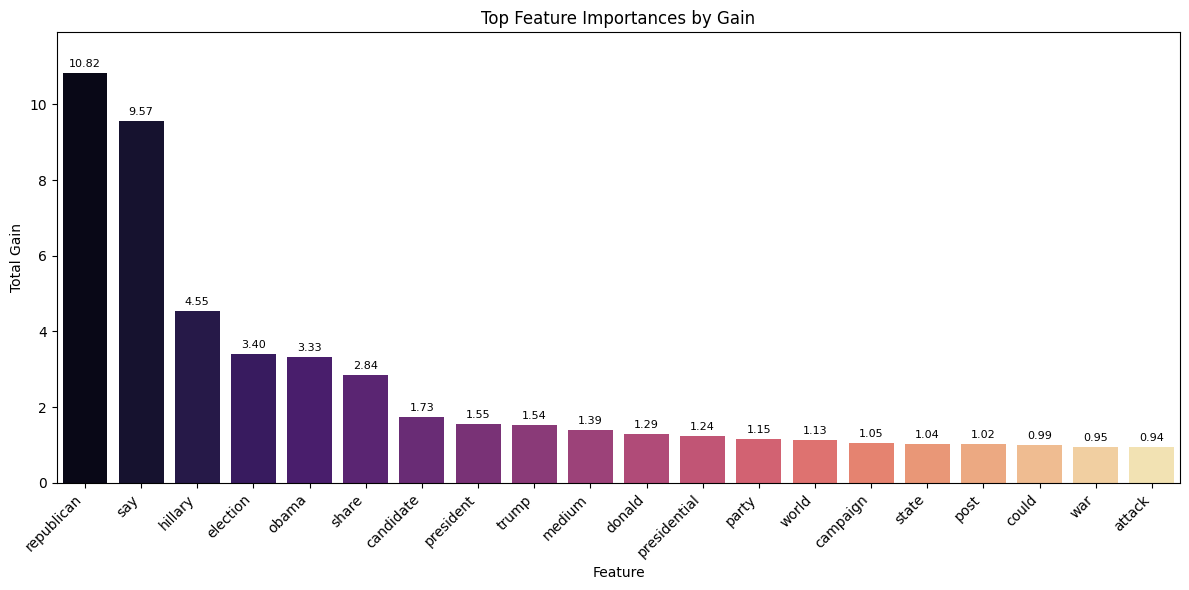

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20

# --- Plot Gain ---
gain_data = importance_df[['feature', 'gain']].sort_values(by='gain', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax1 = sns.barplot(
    data=gain_data,
    x='feature',
    y='gain',
    hue='feature',
    legend=False,
    palette='magma'
)
plt.title('Top Feature Importances by Gain')
plt.xlabel('Feature')
plt.ylabel('Total Gain')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels above bars
gain_max = gain_data['gain'].max()
for i, (feature, value) in enumerate(zip(gain_data['feature'], gain_data['gain'])):
    ax1.text(i, value + 0.01 * gain_max, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

ax1.set_ylim(0, gain_max * 1.1)

plt.tight_layout()
plt.show()


C:\Users\stefa\AppData\Local\Temp\ipykernel_2844\3576524081.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


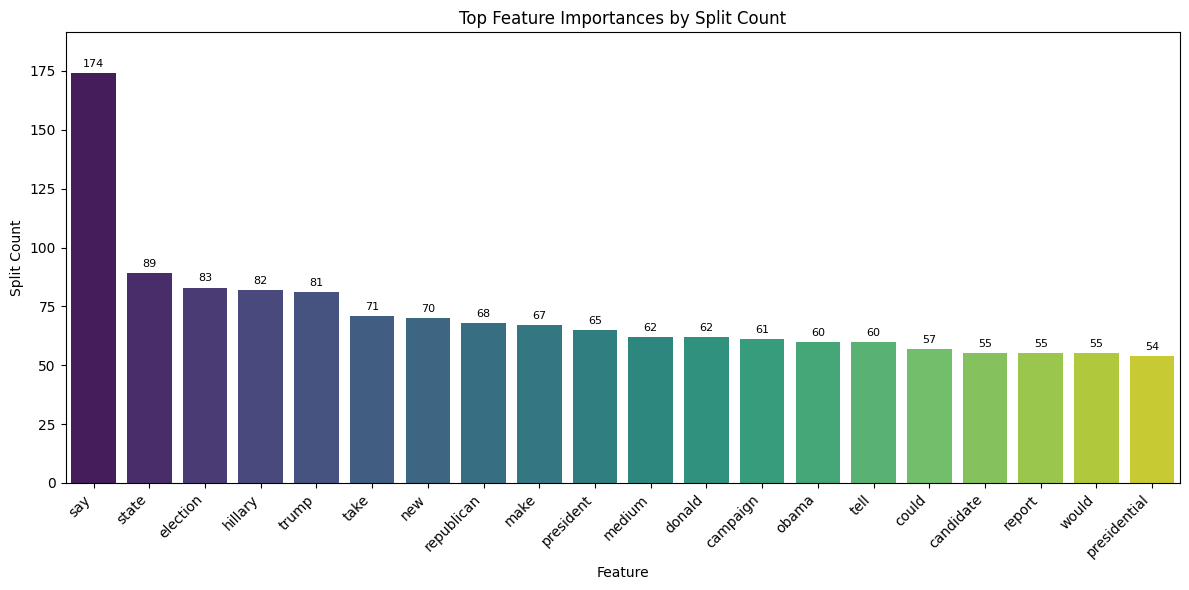

In [28]:
# --- Plot Split ---
split_data = importance_df[['feature', 'split']].sort_values(by='split', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax2 = sns.barplot(
    data=split_data,
    x='feature',
    y='split',
    hue='feature',
    legend=False,
    palette='viridis'
)
plt.title('Top Feature Importances by Split Count')
plt.xlabel('Feature')
plt.ylabel('Split Count')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels above bars
split_max = split_data['split'].max()
for i, (feature, value) in enumerate(zip(split_data['feature'], split_data['split'])):
    ax2.text(i, value + 0.01 * split_max, f'{value:.0f}', ha='center', va='bottom', fontsize=8)

ax2.set_ylim(0, split_max * 1.1)

plt.tight_layout()
plt.show()


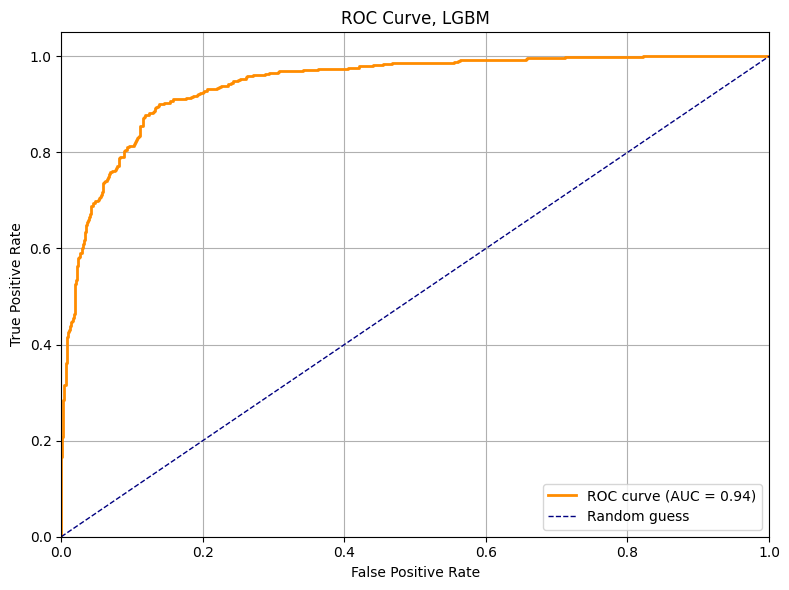

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities (positive class only)
y_proba = final_lgbm.predict_proba(X_test)[:, 1]  # assuming binary classification

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, LGBM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()